Code for preprocessing pairScan data \
Starting from the aligned pseudodiploid bams, we separate them out into wA 0,1,2 \
Then we get allele specific coverage and sequences accordingly \
We save this temporary result in a data_noGC.h5 and then perform GC regression on it \
NOTE: This script only generates data_ident.h5 (ie. no ref or trueref)

In [1]:
# General import, names of train, test, val
%load_ext autoreload
%autoreload 2
import numpy as np
import pysam
from tqdm.notebook import tqdm
import h5py
import pandas as pd
import matplotlib.pyplot as plt
rng = np.random.default_rng(seed=0)

basedir = '/data/leslie/sunge/'
aligndir = f'{basedir}f1_hybrid/iPSC_ATAC_bam/'
ctype = 'iPSC'
strain = 'pwk'
b6_strain = 'b6_pwk'
ident = ''     # ident is '' for you or whatever label you want to use for the h5 data you've generated

datadir = f'{basedir}f1_ASA/{strain}/{ctype}/data/'
chrom_train = [1,2,4,6,7,8,9,11,12,13,14,16,17,18,19]
chrom_val = [3,5]
chrom_test = [10,15]
chroms = [chrom_train, chrom_val, chrom_test]
name = ['train', 'val', 'test']

reps = ['r1','r2','r3']
seqlen = 300                         # region around summit for sequence
seqlen1 = 150                        # region around summit for coverage
save = True                          # failsafe to prevent unwanted overwriting

# Preprocessing of Model Input

In [2]:
import os
# some utility functions
from utils import get_summits, get_shifts, one_hot, GCregress

# make data directory for the cell type - done ONCE
if not os.path.exists(datadir+'bam/'):
    os.makedirs(datadir+'bam/')
    # separate out replicate BAM files based on allele tag wA, to be used for pileup purposes
    for rep in reps:
        bamfile = aligndir+b6_strain+'/'+rep+'.combined.rmDup.Aligned.sortedByCoord.out.bam'
        _ = pysam.index(bamfile)
        bamf = pysam.AlignmentFile(bamfile, "rb")
        temp1 = pysam.AlignmentFile(datadir+'bam/'+rep+'_b6.bam', 'wb', template=bamf)
        temp2 = pysam.AlignmentFile(datadir+'bam/'+rep+'_pwk.bam', 'wb', template=bamf)
        temp3 = pysam.AlignmentFile(datadir+'bam/'+rep+'_both.bam', 'wb', template=bamf)
        i=0
        for read in bamf.fetch():
            try:
                idx = read.get_tag('wA')
                if idx==0:
                    temp1.write(read)
                elif idx==1:
                    temp2.write(read)
                elif idx==2:
                    temp3.write(read)
            except:
                i+=1
        print(i)
        temp1.close()
        temp2.close()
        temp3.close()
        bamf.close()

        _ = pysam.index(datadir+'bam/'+rep+'_b6.bam')
        _ = pysam.index(datadir+'bam/'+rep+'_pwk.bam')
        _ = pysam.index(datadir+'bam/'+rep+'_both.bam')

N = []
for rep in reps:
    bamfile = aligndir+b6_strain+'/'+rep+'.combined.rmDup.Aligned.sortedByCoord.out.bam'
    bamf = pysam.AlignmentFile(bamfile, "rb")
    N.append( sum([bamf.get_index_statistics()[i][1] for i in range(len(chrom_train+chrom_test+chrom_val))]) )
    bamf.close()

0
0
0


In [2]:
import os
# some utility functions
from utils import get_summits, get_shifts, one_hot, GCregress

N = []
for rep in reps:
    print(rep)
    bamfile = aligndir+b6_strain+'/'+rep+'.combined.rmDup.Aligned.sortedByCoord.out.bam'
    bamf = pysam.AlignmentFile(bamfile, "rb")
    N.append( sum([bamf.get_index_statistics()[i][1] for i in range(len(chrom_train+chrom_test+chrom_val))]) )
    bamf.close()

r1
r2
r3


In [6]:
# process peakatlas file to get peaks dataframe
if ident[:3]=='_vi':     # This is us using a peak atlas, you would be using the else clause here
    summits = pd.read_csv(aligndir+'cd8_old/yi_cd8_peaks_33143.csv',sep=',',index_col=0)
    summits['start'] += seqlen//2
    summits = summits.iloc[:,1:3]
    summits.columns = range(2)
    summits_neg = pd.read_csv(aligndir+'cd8_old/yi_cd8_uneg_peaks_33143.csv',sep=',',index_col=0)
    summits_neg['start'] += seqlen//2
    summits_neg = summits_neg.iloc[:,1:3].reset_index(drop=True)
    summits_neg.columns = range(2)
else:
    if ident=='_yi':
        peakfile = aligndir+'cd8_old/peaks_yi.bed'
    else:
        peakfile = aligndir+b6_strain+'/peaks/peakatlas.bed'
    peaks = pd.read_csv(peakfile, sep='\t', header=None)

    if not ident:
        # filter peaks based on IDR threshold (column 12 of BED)
        idr_thresh = 0.05
        idx = np.where( peaks.iloc[:,11] >= -np.log10(idr_thresh) )[0]
        peaks = peaks.loc[idx].reset_index(drop=True)

#     # remove blacklist regions - try with and without
#     blacklistfile = aligndir+'mm10-blacklist.v2.bed'
#     blacklist = pd.read_csv(blacklistfile, sep='\t', header=None)
#     peaks = remove_blacklist(peaks, blacklist)

    # get summits of called + flanking neg peaks (moving away from this to background unegs)
    summits, summits_neg = get_summits(peaks)
    
print("Done")

Done


In [9]:
# Code to shortlist negative flanking summits to low accessibility - not needed if you are doing background unegs
# Shit code, haven't used in forever, might need overhauling
if ident[:3]!='_vi':
    # FOR UNEGS, get the shortlist of summits_neg that have low accessibility
    # get indices for each rep
    idx = dict()
    for rep in tqdm(reps):
        bamfile = aligndir+b6_strain+'/'+rep+'.combined.rmDup.Aligned.sortedByCoord.out.bam'
        bamf = pysam.AlignmentFile(bamfile, "rb")

        idx[rep] = []
        for chrom in chroms[:2]:
            for c in chrom:
                chromsummits = summits_neg.loc[np.where(summits_neg[0]==c)[0]]
                y_uneg = []
                for i in chromsummits[1]:
                    y_uneg.append(bamf.count(str(c),i-seqlen//2,i+seqlen//2))
                idx[rep] += list(chromsummits.index[ np.where(np.array(y_uneg)<5)[0] ])
        bamf.close()

    del y_uneg
    # get low accessibility indices across reps
    temp = set(idx[reps[0]])
    for rep in reps[1:]:
        temp.intersection_update(idx[rep])
    idx = list(temp)

    # shortlist unegs to low accessibility indexes
    summits_neg = summits_neg.loc[idx].reset_index(drop=True)
    frac=0.5
    if len(summits_neg) > frac*len(summits):
        idx = rng.choice(len(summits_neg), int(frac*len(summits)), replace=False)
        summits_neg = summits_neg.loc[idx].reset_index(drop=True)
    summits_neg = summits_neg.sort_values(by=[0,1], ignore_index=True)

    if save:
        summits.to_csv(datadir+'summits'+ident+'.csv', index=False, header=False)
        summits_neg.to_csv(datadir+'summits_neg'+ident+'.csv', index=False, header=False)

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
# # Augment the list of positive summits in train and val by randomly adding seqlen//3 shifts (100bp)
# # I'm experimenting with augmentation, you don't need this right now
# augment = False      # for augmentation of data by shifting sequence window

# if augment:
#     frac = 0.5    
#     # Randomly shift all the summits by + or - seqlen//3
#     summits_aug = summits.copy()
#     shifts = seqlen//3 * rng.choice([-1,1], len(summits), replace=True)
#     summits_aug[1] += shifts
#     # Get total number of summits to be augmented
#     temp = np.unique(summits[0], return_counts=True)
#     num_aug = int(frac*sum(temp[1][np.isin(temp[0],chrom_train+chrom_val)]))
#     # randomly choose the subset of summits to be augmented
#     idx = rng.choice(np.arange(len(summits)), num_aug, replace=False)
#     summits_aug = summits_aug.iloc[idx, :].reset_index(drop=True)
#     summits = pd.concat((summits, summits_aug)).reset_index(drop=True)

In [10]:
# Generate y
# Use summits and BAM files to generate pileup summed accessibilities
y = dict()
for rep in tqdm(reps):
    temp1 = pysam.AlignmentFile(datadir+'bam/'+rep+'_b6.bam', 'rb')
    temp2 = pysam.AlignmentFile(datadir+'bam/'+rep+'_pwk.bam', 'rb')
    temp3 = pysam.AlignmentFile(datadir+'bam/'+rep+'_both.bam', 'rb')

    for n,chrom in zip(name,chroms):
        y[rep+'_'+n+'_b6'] = []
        y[rep+'_'+n+'_pwk'] = []

        for c in chrom:        # for each chromosome in train/val/test set
            chromsummits = summits.iloc[np.where(summits[0]==c)[0],1]     # slice out the relevant chromosome summits
            y_b6 = []
            y_pwk = []
            for i in chromsummits:
                # for each summit peak, get the summed accessibility from BAM pileup
                y1 = temp1.count(str(c),i-seqlen1//2,i+seqlen1//2)
                y2 = temp2.count(str(c),i-seqlen1//2,i+seqlen1//2)
                y3 = temp3.count(str(c),i-seqlen1//2,i+seqlen1//2)
                y_b6.append(y1+y3/2)
                y_pwk.append(y2+y3/2)            
            
            y[rep+'_'+n+'_b6'] += y_b6
            y[rep+'_'+n+'_pwk'] += y_pwk
    
    temp1.close()
    temp2.close()
    temp3.close()
    
del y_b6, y_pwk, y1, y2, y3, chromsummits

# merge RPMs across reps
for n in name:
    y[n+'_b6'] = np.zeros_like(y[rep+'_'+n+'_b6'])
    y[n+'_pwk'] = np.zeros_like(y[rep+'_'+n+'_pwk'])
    for i,rep in enumerate(reps):
        y[n+'_b6'] += np.array(y[rep+'_'+n+'_b6'])*1e6/N[i]         # get summed RPMs
        y[n+'_pwk'] += np.array(y[rep+'_'+n+'_pwk'])*1e6/N[i]     # get summed RPMs
        del y[rep+'_'+n+'_b6'], y[rep+'_'+n+'_pwk']
    
    y[n+'_b6'] = np.log2( 1+y[n+'_b6'] )                  # log normalize
    y[n+'_pwk'] = np.log2( 1+y[n+'_pwk'] )                  # log normalize

  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
# Generate X
# Get coordinate shifts for the pwk corresponding to the summits in b6 coords, and prepare input homologous peak sequences X
import gzip
from Bio import SeqIO
from bisect import bisect

gen_b6 = SeqIO.index(f'{basedir}f1_hybrid/gen/b6.fa', 'fasta')
gen_pwk = SeqIO.index(f'{basedir}f1_hybrid/gen/pwk.fa', 'fasta')

modfile = f'{basedir}f1_hybrid/gen/pwk.mod'
with gzip.open(modfile,'rt') as f:
    mods = f.read().split('\n')
    mods = [x for x in mods if not (x.startswith('s') or x.startswith('#'))][:-1]            # filter out SNPs and header lines

x = dict()
for n,chrom in zip(name,chroms):
    x[n+'_b6'] = []
    x[n+'_pwk'] = []
    if n!='test' and not summits_neg.empty:
        x[n+'_b6_unegs'] = []
        x[n+'_pwk_unegs'] = []

    for c in tqdm(chrom):        # for each chromosome in train/val/test set
        seq_b6 = ''.join(gen_b6.get_raw(str(c)).decode().split('\n')[1:])
        seq_pwk = ''.join(gen_pwk.get_raw(str(c)).decode().split('\n')[1:])

        chromsummits = summits.iloc[np.where(summits[0]==c)[0],1]     # slice out the relevant chromosome summits
        pwk_shifts = get_shifts(chromsummits, mods, c)

        # get relevant b6 genomic seqs
        x[n+'_b6'] += [seq_b6[i-seqlen//2:i+seqlen//2] for i in chromsummits]
        # add corresponding pwk genomic seqs
        x[n+'_pwk'] += [seq_pwk[i+j-seqlen//2:i+j+seqlen//2] for i,j in zip(chromsummits,pwk_shifts)]

        if n!='test' and not summits_neg.empty:
            chromsummits = summits_neg.loc[np.where(summits_neg[0]==c)[0],1]     # slice out the relevant chromosome summits
            x[n+'_b6_unegs'] += [seq_b6[i-seqlen//2:i+seqlen//2] for i in chromsummits]
            pwk_shifts = get_shifts(chromsummits, mods, c)
            x[n+'_pwk_unegs'] += [seq_pwk[i+j-seqlen//2:i+j+seqlen//2] for i,j in zip(chromsummits,pwk_shifts)]

    x[n+'_b6'] = one_hot(x[n+'_b6'])             # convert string of nucleotides to one-hot representation
    x[n+'_pwk'] = one_hot(x[n+'_pwk'])
    if n!='test' and not summits_neg.empty:
        x[n+'_b6_unegs'] = one_hot(x[n+'_b6_unegs'])
        x[n+'_pwk_unegs'] = one_hot(x[n+'_pwk_unegs'])

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
import gzip
from Bio import SeqIO
from bisect import bisect

gen_b6 = SeqIO.index(f'{basedir}f1_hybrid/gen/b6.fa', 'fasta')
gen_pwk = SeqIO.index(f'{basedir}f1_hybrid/gen/pwk.fa', 'fasta')

modfile = f'{basedir}f1_hybrid/gen/pwk.mod'
with gzip.open(modfile,'rt') as f:
    mods = f.read().split('\n')
    mods = [x for x in mods if not (x.startswith('s') or x.startswith('#'))][:-1]            # filter out SNPs and header lines

In [ ]:
# new code for actual background unegs - can be merged into x code later - SKIP till SKIP END if dont need to compute
# written very stupidly, basically just overwrite the old unegs
# this is because I didn't want to write logic to do one or the other depending on which method of unegs you want
from utils import get_neg_summits

bamfile = aligndir+b6_strain+'/'+reps[0]+'.combined.rmDup.Aligned.sortedByCoord.out.bam'
bamf = pysam.AlignmentFile(bamfile, "rb")

for n,chrom in zip(name,chroms[:2]):
    x[n+'_b6_unegs'] = []
    x[n+'_pwk_unegs'] = []
    
    for c in tqdm(chrom):        # for each chromosome in train/val/test set
        print(c)
        seq_b6 = ''.join(gen_b6.get_raw(str(c)).decode().split('\n')[1:])
        seq_pwk = ''.join(gen_pwk.get_raw(str(c)).decode().split('\n')[1:])
        
        chromsummits = summits.iloc[np.where(summits[0]==c)[0],1]     # slice out the relevant chromosome summits
        neg_summits = np.empty(0, dtype=np.int64)
        seed = 0
        while len(neg_summits)<len(chromsummits):     # get neg summits and only keep low coverage ones (<5)
            temp = get_neg_summits(chromsummits, len(chromsummits)-len(neg_summits), len(seq_b6), seed)
            idx = np.where(np.array([bamf.count(str(c),i-seqlen//2,i+seqlen//2) for i in temp]) < 5)[0]
            temp = temp[idx]
            neg_summits = np.concatenate((neg_summits, temp))
            seed += 1
        neg_summits = np.sort(neg_summits)
        
        # get relevant b6 genomic seqs
        x[n+'_b6_unegs'] += [seq_b6[i-seqlen//2:i+seqlen//2] for i in neg_summits]
        pwk_shifts = get_shifts(neg_summits, mods, c)
        x[n+'_pwk_unegs'] += [seq_pwk[i+j-seqlen//2:i+j+seqlen//2] for i,j in zip(neg_summits,pwk_shifts)]
        
    x[n+'_b6_unegs'] = one_hot(x[n+'_b6_unegs'])
    x[n+'_pwk_unegs'] = one_hot(x[n+'_pwk_unegs'])
# SKIP END - comment upto here if you want to skip the background sampling and go with flank regions instead

gen_b6.close()
gen_pwk.close()

# set uneg log acc to low constant value (at tail end of post-GC residual accessibility distribution)
for n,chrom in zip(name[:2],chroms[:2]):
    y[n+'_unegs'] = -5.0*np.ones(len(x[n+'_b6_unegs']))

# Finally, save everything...
if save:
    with h5py.File(datadir+'data_noGC_trueuneg'+ident+'.h5','w') as f:
        for key in x.keys():
            f.create_dataset('x_'+key, data=x[key])
        for key in y.keys():
            f.create_dataset('y_'+key, data=y[key])

  0%|          | 0/15 [00:00<?, ?it/s]

1
2


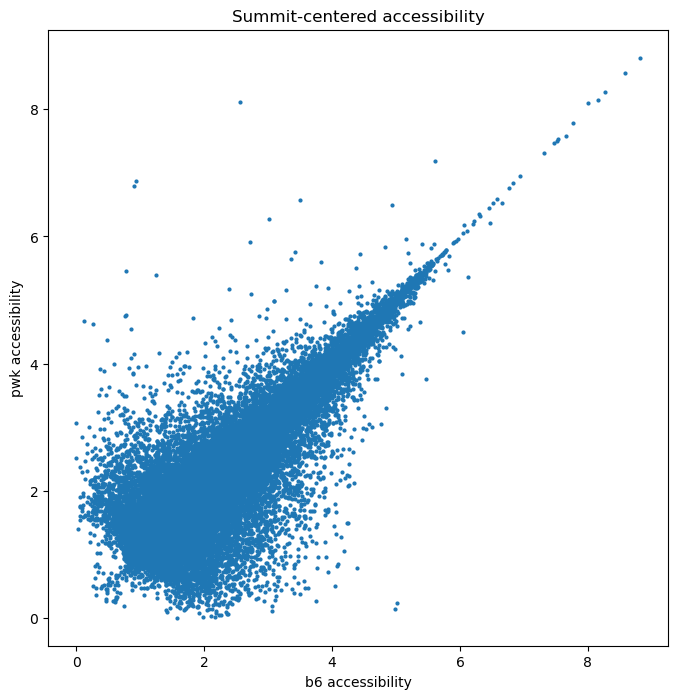

In [14]:
# Visualize the training data allele-specific coverage
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

ax.scatter(y['train_b6'],y['train_pwk'], s=4)
plt.title('Summit-centered accessibility')
ax.set_xlabel('b6 accessibility')
ax.set_ylabel('pwk accessibility')
plt.show()

## Perform GC regression

In [4]:
# Start afresh, load your noGC data
x = dict()
y = dict()
with h5py.File(datadir+'data_noGC'+ident+'.h5','r') as f:
    for n in name:
        for allele in ['b6','pwk']:
            x[n+'_'+allele] = f['x_'+n+'_'+allele][()]
            y[n+'_'+allele] = f['y_'+n+'_'+allele][()]
            if n!='test':
                x[n+'_'+allele+'_unegs'] = f['x_'+n+'_'+allele+'_unegs'][()]
        if n!='test':
            y[n+'_unegs'] = f['y_'+n+'_unegs'][()]

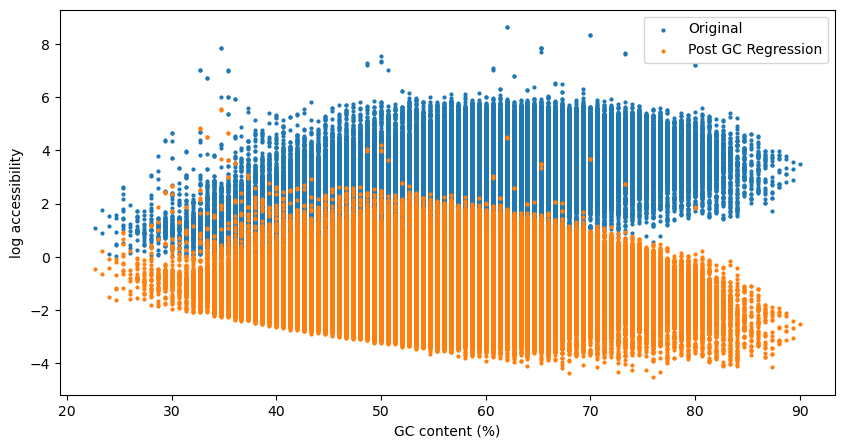

In [28]:
# Visualize the GC-count relationship
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()

temp_x = np.vstack([x[k] for k in x.keys() if 'unegs' not in k])
temp_y = np.concatenate([y[k] for k in y.keys() if 'unegs' not in k])
GC = np.sum(temp_x[:,(seqlen//2-seqlen1//2):(seqlen//2+seqlen1//2),:], axis=1)
GC = GC[:,1]+GC[:,2]
ax.scatter(GC/seqlen1*100, temp_y, s=4, label = "Original")
coef = GCregress(temp_x[:,(seqlen//2-seqlen1//2):(seqlen//2+seqlen1//2),:], temp_y)    # limit GC counting to only the window where reads are counted
temp_y -= coef*GC
ax.scatter(GC/seqlen1*100, temp_y, s=4, label = "Post GC Regression")
ax.set_xlabel('GC content (%)')
ax.set_ylabel('log accessibility')
ax.legend()
plt.show()

In [9]:
# Regress out GC content
temp_x = np.vstack([x[k] for k in x.keys() if 'unegs' not in k])      # don't use uneg sequence trends for bias correction
temp_y = np.concatenate([y[k] for k in y.keys() if 'unegs' not in k])
coef = GCregress(temp_x[:,(seqlen//2-seqlen1//2):(seqlen//2+seqlen1//2),:], temp_y)    # limit GC counting to only the window where reads are counted

for n in name:
    for allele in ['b6','pwk']:
        GC = np.sum(x[n+'_'+allele][:,(seqlen//2-seqlen1//2):(seqlen//2+seqlen1//2),:], axis=1)
        GC = GC[:,1]+GC[:,2]
        y[n+'_'+allele] -= coef*GC

/scratch/lsftmp/19393717.tmpdir/ipykernel_485395/2619021051.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(y['train_b6'], y['train_pwk'],


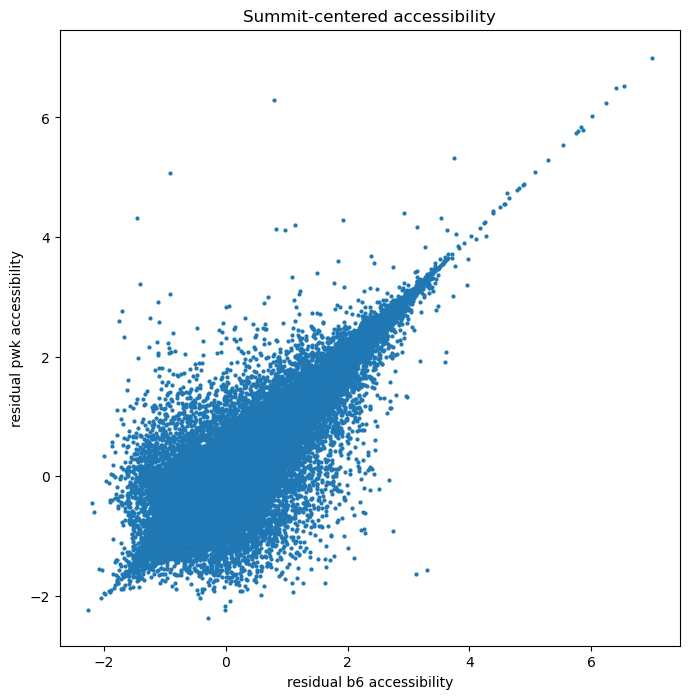

In [18]:
# Visualize GC regressed data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

ax.scatter(y['train_b6'], y['train_pwk'],
            vmax = 2, vmin = -2, s = 4)
plt.title('Summit-centered accessibility')
ax.set_xlabel('residual b6 accessibility')
ax.set_ylabel('residual pwk accessibility')
plt.show()

In [ ]:
## Seeing the distribution above, you might want to change the uneg constant value, which you can do with this code
# print(np.unique(y['train_unegs']))
# y['train_unegs']-= some_value
# y['val_unegs']-= some_value

In [10]:
# Save everything to new file to be used by the model. A good sanity check is to see if your uneg data is the same
if save:
    with h5py.File(datadir+'data_trueuneg'+ident+'.h5','w') as f:
        for key in x.keys():
            f.create_dataset('x_'+key, data=x[key])
        for key in y.keys():
            f.create_dataset('y_'+key, data=y[key])